<a href="https://colab.research.google.com/github/Mahalakshmi-Telidevara/enchantedWingsMarvelsOfButterflySpecies/blob/main/Project/enchantedWingsMarvelsOfButterflySpecies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from google.colab import files
uploaded = files.upload()
import zipfile
import os

with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('train')

with zipfile.ZipFile('test.zip', 'r') as zip_ref:
    zip_ref.extractall('test')

print("Train files:", os.listdir("train")[:5])
print("Test files:", os.listdir("test")[:5])

Saving train.zip to train.zip
Saving test.zip to test.zip
Train files: ['train']
Test files: ['test']


In [6]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

In [2]:
train_df = pd.read_csv("Training_set.csv")
test_df = pd.read_csv("Testing_set.csv")

# Inspect structure
print(train_df.head())
print(test_df.head())


      filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART
      filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg


In [3]:
print(train_df.columns)
print(test_df.columns)

Index(['filename', 'label'], dtype='object')
Index(['filename'], dtype='object')


In [11]:
import os

print("train folder:", os.listdir("train")[:5])
print("test folder:", os.listdir("test")[:5])


train folder: ['train']
test folder: ['test']


In [34]:
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os

# Reset filenames to original (critical if cell is rerun)
train_df['filename'] = train_df['filename'].apply(lambda x: os.path.basename(x))
test_df['filename'] = test_df['filename'].apply(lambda x: os.path.basename(x))

# Prepend actual folder path once
train_df['filename'] = "train/train/" + train_df['filename']
test_df['filename'] = "test/test/" + test_df['filename']

# Double check
print("Sample train image path:", train_df['filename'].iloc[0])
print("Exists?", os.path.exists(train_df['filename'].iloc[0]))

# Train/val split
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

# Save class labels
class_labels = train_gen.class_indices
inv_class_labels = {v: k for k, v in class_labels.items()}

with open("class_labels.json", "w") as f:
    json.dump(inv_class_labels, f)

print("class_labels.json saved!")

# Test generator
test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col=None,
    target_size=(224, 224),
    class_mode=None,
    batch_size=32,
    shuffle=False
)


Sample train image path: train/train/Image_3146.jpg
Exists? True
Found 1088 validated image filenames belonging to 75 classes.
Found 273 validated image filenames belonging to 75 classes.
class_labels.json saved!
Found 2786 validated image filenames.


In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(75, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False  # freeze base layers

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=10)
model.save("vgg16_butterfly_model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 51s 982ms/step - accuracy: 0.0198 - loss: 5.3325 - val_accuracy: 0.0235 - val_loss: 4.2672
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 484ms/step - accuracy: 0.0197 - loss: 4.2935 - val_accuracy: 0.0176 - val_loss: 4.2861
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 495ms/step - accuracy: 0.0226 - loss: 4.2947 - val_accuracy: 0.0264 - val_loss: 4.2302
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.0177 - loss: 4.2673 - val_accuracy: 0.0264 - val_loss: 4.2297
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 475ms/step - accuracy: 0.0223 - loss: 4.2364 - val_accuracy: 0.0352 - val_loss: 4.1994
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 498ms/step - accuracy: 0.0274 - loss: 4.2287 - val_accuracy: 0.0381 - val_loss: 4.1260
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 484ms/step - accuracy: 0.0246 - loss: 4.2043 - val_accuracy: 0.0235 - val_loss: 4.0804
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 472ms/step - accuracy: 0.0281 - loss: 4.1432 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


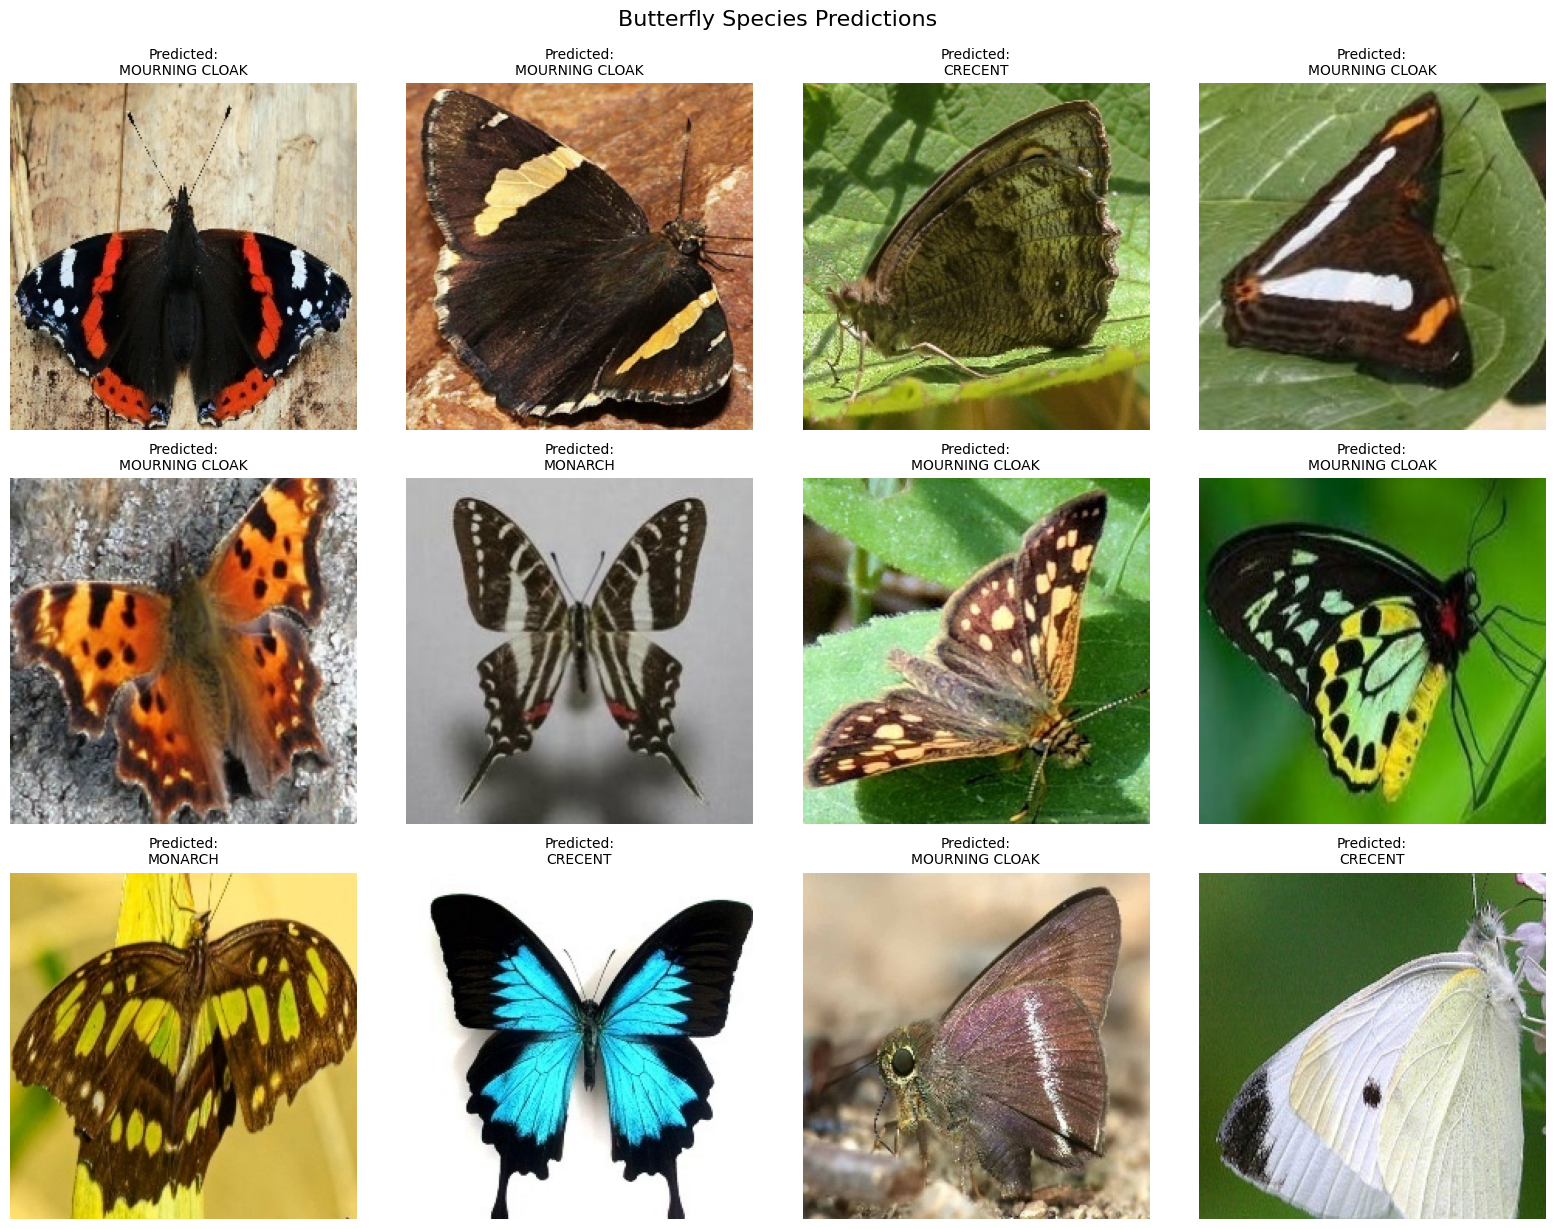

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on a few test images
sample_batch = next(test_gen)
images = sample_batch[:12]  # Show first 12 images
pred_probs = model.predict(images)
pred_indices = np.argmax(pred_probs, axis=1)

# Load class labels
with open("class_labels.json", "r") as f:
    class_labels = json.load(f)

# Decode predictions
decoded_preds = [class_labels[str(i)] for i in pred_indices]

# Plotting
plt.figure(figsize=(16, 12))
for i in range(len(images)):
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"Predicted:\n{decoded_preds[i]}", fontsize=10)
plt.tight_layout()
plt.suptitle("Butterfly Species Predictions", fontsize=16, y=1.02)
plt.show()


In [26]:
%%writefile app.py
import streamlit as st
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import json
import os

# Streamlit UI
st.title("🦋 Butterfly Species Classifier (VGG16)")
st.write("Upload a butterfly image to classify its species.")

model_path = "vgg16_butterfly_model.h5"
labels_path = "class_labels.json"

# Check model file
if not os.path.exists(model_path):
    st.error("Model file not found! Please upload vgg16_butterfly_model.h5")
else:
    try:
        model = load_model(model_path)

        if os.path.exists(labels_path):
            with open(labels_path, "r") as f:
                class_labels = json.load(f)
        else:
            st.error("class_labels.json not found!")
            class_labels = None

        # File uploader
        uploaded_file = st.file_uploader("Upload a butterfly image...", type=["jpg", "jpeg", "png"])
        if uploaded_file is not None:
            img = Image.open(uploaded_file).resize((224, 224))
            st.image(img, caption="Uploaded Image", use_column_width=True)

            img_array = image.img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            pred = model.predict(img_array)
            pred_index = str(np.argmax(pred))

            if class_labels and pred_index in class_labels:
                st.success(f"**Prediction:** {class_labels[pred_index]}")
            else:
                st.success(f"**Prediction (Raw Index):** {pred_index}")
            st.write(f"**Confidence:** {np.max(pred):.4f}")
    except Exception as e:
        st.error(f"Error: {str(e)}")


Writing app.py


In [29]:
# Install requirements
!pip install streamlit -q


In [32]:
!wget -q -O - ipv4.icanhazip.com

34.125.126.231


In [ ]:
# Start Streamlit app and expose with LocalTunnel
!streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸⠼⠴
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.126.231:8501

⠦⠧⠇⠏your url is: https://eager-mails-obey.loca.lt
2025-07-22 14:32:41.443442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753194761.467352   59503 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753194761.474403   59503 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-22 14:32:45.455561: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config va